# Auto-Correlation, PWC -- optimal - sharpness and localization

=== Regularized Sharpness (simplified) — hierarchical PWC-β ===

--- Regular 3×3 ---
[const-β*] β≈6,  S_reg≈0.4127
[L=1] S_reg*=0.4113,  β*=[5.]
[L=2] S_reg*=0.4013,  β*=[7.25 4.5 ]
[L=4] S_reg*=0.4006,  β*=[7.25 7.25 4.5  4.25]
[L=8] S_reg*=0.4006,  β*=[7.25 7.25 7.25 7.25 4.5  4.5  4.25 4.25]

--- Perturbed A ---
[const-β*] β≈6,  S_reg≈0.4157
[L=1] S_reg*=0.416,  β*=[5.5]
[L=2] S_reg*=0.4067,  β*=[7.5 5. ]
[L=4] S_reg*=0.3957,  β*=[7.5 8.5 6.5 2. ]
[L=8] S_reg*=0.3873,  β*=[7.5   7.5   9.5   9.5   9.    6.5   0.001 2.   ]

--- Perturbed B ---
[const-β*] β≈6,  S_reg≈0.406
[L=1] S_reg*=0.4056,  β*=[5.5]
[L=2] S_reg*=0.3968,  β*=[7.25 4.5 ]
[L=4] S_reg*=0.3868,  β*=[7.25 8.   6.   1.5 ]
[L=8] S_reg*=0.3744,  β*=[ 7.25   7.25   9.5   10.    10.     6.     0.001  1.   ]


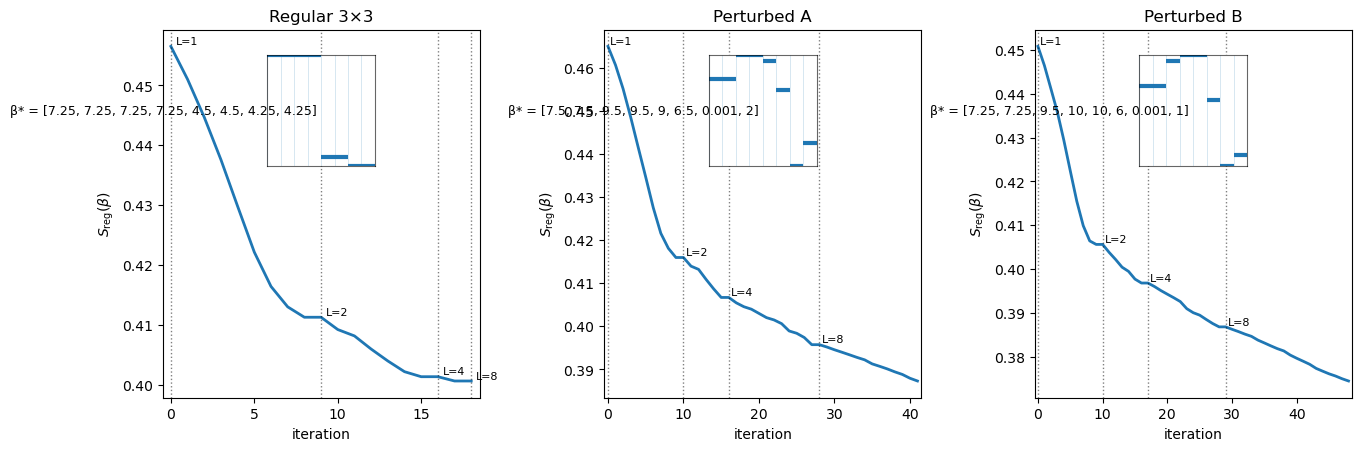

[saved] figs/regsharp_convergence_3models.png


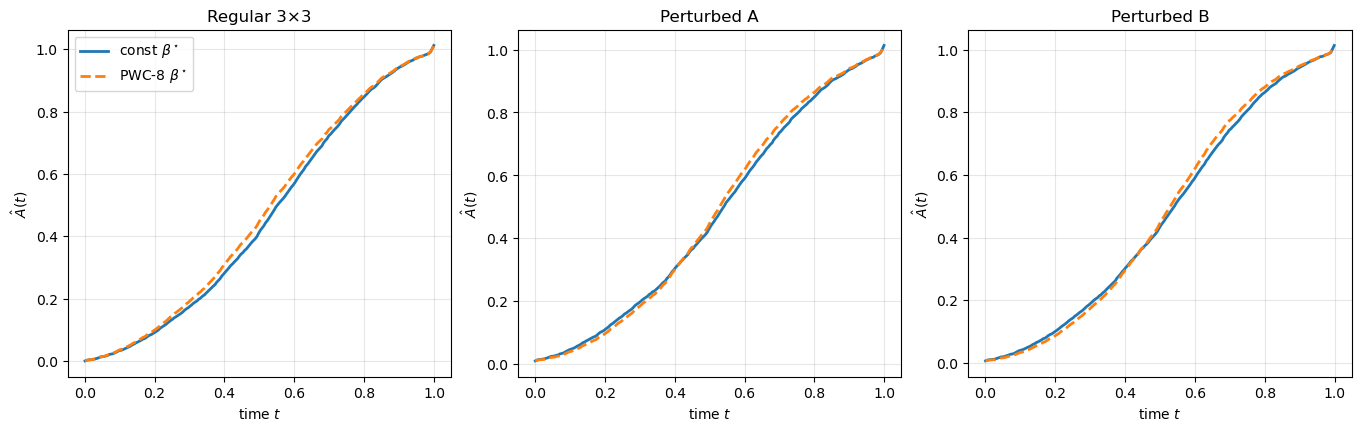

[saved] figs/regsharp_Ahat_curves_3models.png


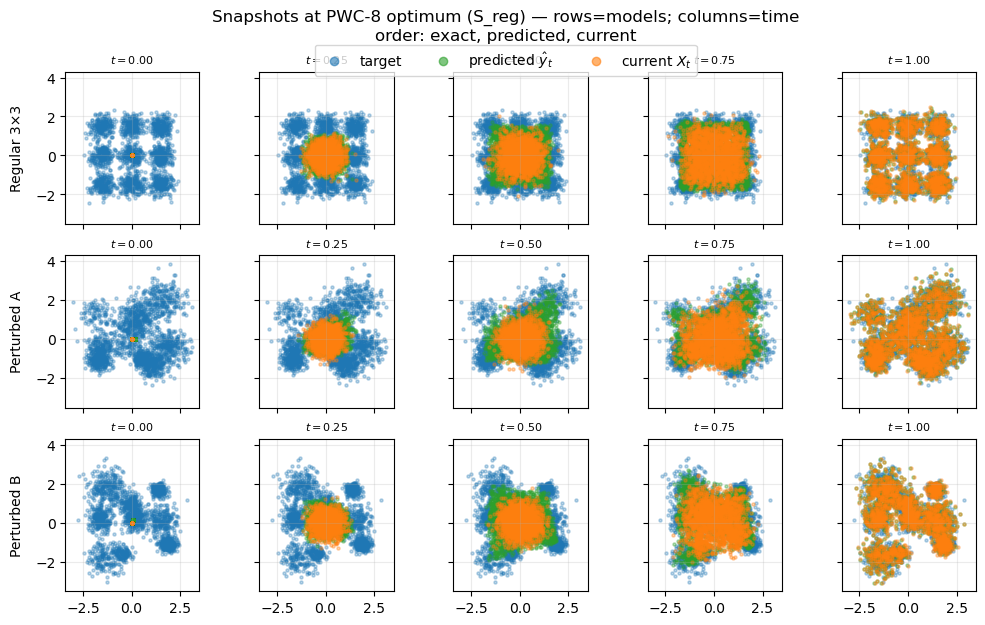

[saved] figs/regsharp_snapshots_PWC8_3models.png


In [3]:
import numpy as np, math, os, time
import matplotlib.pyplot as plt
from ada_api_clean import *  # uses yhat_oracle_gmm, GMM, sample_gmm, regular, pertA, pertB

os.makedirs("figs", exist_ok=True)


# ============================================================
# Regularized Sharpness (simplified objective) — 1 → 2 → 4 → 8 PWC-β
# Objective:
#   S_reg(β) = Shat(β) + λ_trans * (t_star(β) - t_trans)_+^2,
#   where Shat(β) = ∫_0^1 ( 1 - | 2·Ahat(t;β) - 1 | ) dt  (smaller = sharper),
#         t_star    = first t where Ahat(t;β) ≥ 0.5 (first crossing),
#         (·)_+     = max(·, 0).
#
# Figures (per model):
#   (1) Convergence vs iteration (3 subplots, per-axes scaling),
#       with top-centered inset showing final β(t) and the β values.
#   (2)  Ahat(t): const-β* vs PWC-8* (no \mathcal).
#   (3)  3×5 snapshot grids at PWC-8*: order = exact (target), predicted, current.
# ============================================================

import numpy as np, math, os, time
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)

# ---------------------------- model builders ----------------------------
def build_regular_grid_gmm(a=1.5, sigma=0.3):
    xs = np.array([-a, 0.0, a], float)
    MU  = np.array([[xi, yj] for yj in xs for xi in xs], float)
    SIG = np.full(9, float(sigma))
    PI  = np.ones(9, float)/9.0
    return GMM(MU, SIG, PI)

def build_perturbed_gmm(seed, a=1.5, base_sigma=0.3,
                        jitter_frac=1/3, sig_scale=(0.5, 2.0),
                        weight_range=(0.5, 1.5)):
    rng = np.random.default_rng(int(seed))
    xs = np.array([-a, 0.0, a], float)
    centers = np.array([[xi, yj] for yj in xs for xi in xs], float)
    jitter_max = a * float(jitter_frac)
    MU  = centers + rng.uniform(-jitter_max, jitter_max, size=centers.shape)
    SIG = base_sigma * rng.uniform(sig_scale[0], sig_scale[1], size=9)
    w   = rng.uniform(weight_range[0], weight_range[1], size=9)
    PI  = w / np.sum(w)
    return GMM(MU, SIG, PI)

# ---------------------------- schedule builder ----------------------------
def make_pwc_schedule(splits, betas):
    splits = np.asarray(splits, float)
    betas  = np.asarray(betas, float)
    assert len(splits) == len(betas) + 1
    assert np.all(np.diff(splits) > 0)
    tried = []
    for ctor in (
        lambda: BetaSchedulePWC.PWC(splits=splits, betas=betas),
        lambda: BetaSchedulePWC(betas=betas, splits=splits),
        lambda: BetaSchedulePWC.piecewise_constant(splits=splits, betas=betas),
    ):
        try:
            sched = ctor()
            # quick interior health probes
            for tp in (0.15, 0.35, 0.65, 0.85):
                a, K, g = alpha_K_gamma_from_schedule(sched, float(tp))
                if not (np.isfinite(a) and np.isfinite(K) and K>0 and np.isfinite(g) and g>0):
                    raise RuntimeError("health probe failed")
            return sched
        except Exception as e:
            tried.append(repr(e))
    raise RuntimeError("Could not build PWC schedule:\n" + "\n".join(tried))

# ---------------------------- simulate & Ahat(t) ----------------------------
def simulate_paths(sched, gmm, *, M=2000, T=500, seed=0, t_low=0.01, eval_idx=None):
    """
    Midpoint EM, X(0)=0, unit diffusion.
    Returns: t_eval, X_snaps (K,M,d), Yhat_snaps (K,M,d), X_T (M,d)
    """
    rng = np.random.default_rng(seed)
    dt = 1.0 / T
    d  = gmm.d
    X  = np.zeros((M, d), float)

    if eval_idx is None:
        idx = np.linspace(0, T-1, 48).round().astype(int)
        idx = np.unique(np.clip(idx, 0, T-1))
    else:
        idx = np.asarray(eval_idx, int)
    t_eval = (idx + 0.5) / T
    idx_set = set(idx.tolist())

    K = len(idx)
    X_snaps    = np.empty((K, M, d), float)
    Yhat_snaps = np.empty_like(X_snaps)

    k = 0
    for n in range(T):
        t_mid = (n + 0.5)/T
        t_eff = min(max(t_mid, float(t_low)), 1.0 - float(t_low))
        yhat  = yhat_oracle_gmm(X, float(t_eff), sched, gmm)
        a_m   = float(sched.a_minus(float(t_eff)))
        b_m   = float(sched.b_minus(float(t_eff)))
        u     = b_m * yhat - a_m * X

        if n in idx_set:
            X_snaps[k,:,:]    = X
            Yhat_snaps[k,:,:] = yhat
            k += 1

        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    X_T = X.copy()
    return t_eval, X_snaps[:k], Yhat_snaps[:k], X_T

def _Shat_integrand(A):
    # 1 - |2A - 1|  (small = sharper)
    return 1.0 - np.abs(2.0*A - 1.0)

def _first_crossing_time_half(t_eval, Ahat):
    """First t where Ahat(t) >= 0.5, linear interpolation between samples.
       If never crosses, return 1.0.
    """
    for i in range(1, len(t_eval)):
        if Ahat[i-1] < 0.5 <= Ahat[i]:
            # linear interp in segment [i-1, i]
            t0, t1 = t_eval[i-1], t_eval[i]
            a0, a1 = Ahat[i-1], Ahat[i]
            if a1 == a0:
                return float(t1)
            frac = (0.5 - a0) / (a1 - a0)
            return float(t0 + frac*(t1 - t0))
    return 1.0

def ahat_and_regularized_sharpness(sched, gmm, *, M=2000, T=500, seed=0, t_low=0.01, N_eval=48,
                                   lam_trans=1.0, t_trans=0.5):
    idx = np.linspace(0, T-1, int(N_eval)).round().astype(int)
    t_eval, Xs, Ys, X_T = simulate_paths(sched, gmm, M=M, T=T, seed=seed, t_low=t_low, eval_idx=idx)

    denom = float(np.mean(np.sum(X_T*X_T, axis=1))) + 1e-30
    Ahat = np.array([float(np.mean(np.sum(Ys[k]*X_T, axis=1))) / denom for k in range(len(t_eval))])

    Shat = float(np.trapz(_Shat_integrand(Ahat), t_eval))  # small = sharp
    tstar = _first_crossing_time_half(t_eval, Ahat)
    penalty = float(lam_trans * max(0.0, tstar - float(t_trans))**2)
    return t_eval, Ahat, Shat, tstar, Shat + penalty

# ---------------------------- objective wrapper ----------------------------
def objective_sharpness_reg(betas, splits, gmm, *, M, T, seed, t_low, N_eval,
                            lam_trans, t_trans):
    try:
        sched = make_pwc_schedule(splits, betas)
        for tp in (0.12, 0.28, 0.58, 0.82):
            a, K, g = alpha_K_gamma_from_schedule(sched, float(tp))
            if not (np.isfinite(a) and np.isfinite(K) and K>0 and np.isfinite(g) and g>0):
                return np.inf
        _, _, _, _, Sreg = ahat_and_regularized_sharpness(
            sched, gmm, M=M, T=T, seed=seed, t_low=t_low, N_eval=N_eval,
            lam_trans=lam_trans, t_trans=t_trans
        )
        return Sreg
    except Exception:
        return np.inf

# ---------------------------- coordinate descent (step halving, fine step_min) ----------------------------
def coord_descent_sharpness_reg(
    betas0, splits, gmm, *, M, T, seed, t_low, N_eval, lam_trans, t_trans,
    step0=0.5, step_min=1e-4, improve_tol=5e-4, max_sweeps=20,
    BETA_MIN=1e-3, BETA_MAX=12.0, record=None
):
    b = np.asarray(betas0, float).copy()
    fbest = objective_sharpness_reg(b, splits, gmm, M=M, T=T, seed=seed, t_low=t_low, N_eval=N_eval,
                                    lam_trans=lam_trans, t_trans=t_trans)
    if record is not None: record.append(fbest)

    step = float(step0)
    for _ in range(max_sweeps):
        improved = False
        for k in range(len(b)):
            for sgn in (+1, -1):
                cand = b.copy()
                cand[k] = np.clip(cand[k] + sgn*step, BETA_MIN, BETA_MAX)
                f = objective_sharpness_reg(cand, splits, gmm, M=M, T=T, seed=seed, t_low=t_low, N_eval=N_eval,
                                            lam_trans=lam_trans, t_trans=t_trans)
                if f + improve_tol < fbest:
                    b, fbest = cand, f
                    improved = True
                    if record is not None: record.append(fbest)
        if not improved:
            step *= 0.5
            if step < step_min:
                break
    return b, float(fbest)

# ---------------------------- utilities for insets & plots ----------------------------
def draw_beta_step(ax, splits, betas):
    for i in range(len(betas)):
        ax.hlines(betas[i], splits[i], splits[i+1], lw=3)
        ax.vlines(splits[i], min(betas), max(betas), lw=0.5, alpha=0.25)
    ax.vlines(splits[-1], min(betas), max(betas), lw=0.5, alpha=0.25)
    ax.set_xlim(0,1); ax.set_ylim(min(betas)-1e-9, max(betas)+1e-9)
    ax.set_xticks([]); ax.set_yticks([])

def annotate_beta_values_center(ax, betas):
    text = "β* = [" + ", ".join(f"{b:.3g}" for b in betas) + "]"
    ax.text(0.46, 0.50, text, ha="right", va="center", fontsize=9, transform=ax.transAxes)  # shifted left a bit

# ---------------------------- three models ----------------------------
models = [("Regular 3×3", regular), ("Perturbed A", pertA), ("Perturbed B", pertB)]



# ---------------------------- runtime knobs & regularization ----------------------------
M_eval   = 2000
T_eval   = 500
N_eval   = 200
seed_sim = 20241012
t_low    = 0.01

BETA_MIN, BETA_MAX = 1e-3, 12.0
beta_init = 1.0
levels = [1,2,4,8]

# Regularization terms (you can tweak these)
LAM_TRANS = 10.0         # λ^{(trans)}
T_TRANS   = 0.50        # desired transition (first crossing of 1/2)

# baseline sweep for const-β* under the SAME objective
beta_sweep = np.array([0.05, 0.1, 0.18, 0.25, 0.35, 0.5, 0.7, 1.0, 1.4, 2.0, 2.8, 4.0, 6.0, 8.0, 10.0, 12.0], float)

best_records   = {}
series_records = {}
Acurves_records= {}

print("=== Regularized Sharpness (simplified) — hierarchical PWC-β ===")

for name, gmm in models:
    print(f"\n--- {name} ---")

    # 1) const-β* for S_reg
    best_f, best_b = np.inf, None
    for b in beta_sweep:
        f = objective_sharpness_reg([b], np.array([0.0,1.0]), gmm,
                                    M=M_eval, T=T_eval, seed=seed_sim, t_low=t_low, N_eval=N_eval,
                                    lam_trans=LAM_TRANS, t_trans=T_TRANS)
        if f < best_f:
            best_f, best_b = f, float(b)
    best_records[(name,"const")] = dict(beta=best_b, f=best_f)
    print(f"[const-β*] β≈{best_b:.3g},  S_reg≈{best_f:.4g}")

    # 2) hierarchical 1→2→4→8 with same objective
    traj_f = []; level_marks = []
    b_parent = np.array([beta_init], float); splits_parent = np.array([0.0,1.0], float)

    for L in levels:
        if L == 1:
            splitsL = splits_parent.copy(); b_init = b_parent.copy()
        else:
            splitsL = np.linspace(0.0, 1.0, L+1)
            # init children with parent's β via nearest parent-interval midpoint
            b_init = np.empty(L, float)
            parent_edges = np.linspace(0,1,len(b_parent)+1)
            for i in range(L):
                t_mid = 0.5*(splitsL[i] + splitsL[i+1])
                j = max(0, min(len(b_parent)-1, np.searchsorted(parent_edges, t_mid, 'right')-1))
                b_init[i] = float(b_parent[j])

        start_idx = len(traj_f)
        b_star, f_star = coord_descent_sharpness_reg(
            b_init, splitsL, gmm,
            M=M_eval, T=T_eval, seed=seed_sim, t_low=t_low, N_eval=N_eval,
            lam_trans=LAM_TRANS, t_trans=T_TRANS,
            step0=0.5, step_min=1e-4, improve_tol=5e-4, max_sweeps=20,
            BETA_MIN=BETA_MIN, BETA_MAX=BETA_MAX, record=traj_f
        )
        level_marks.append(start_idx)
        best_records[(name,L)] = dict(betas=b_star.copy(), f=float(f_star), splits=splitsL.copy())
        print(f"[L={L}] S_reg*={f_star:.4g},  β*={np.array2string(b_star, precision=3)}")

        b_parent, splits_parent = b_star.copy(), splitsL.copy()

    # record convergence
    series_records[name] = dict(traj_f=np.array(traj_f, float), level_marks=np.array(level_marks, int))

    # store Ahat(t) for const-β* and PWC-8*
    t_c, Ahat_c, Sh_c, tstar_c, Sreg_c  = ahat_and_regularized_sharpness(
        BetaSchedulePWC.constant(best_b), gmm,
        M=M_eval, T=T_eval, seed=seed_sim, t_low=t_low, N_eval=N_eval,
        lam_trans=LAM_TRANS, t_trans=T_TRANS
    )
    item8 = best_records[(name,8)]
    sched8 = make_pwc_schedule(item8["splits"], item8["betas"])
    t_p, Ahat_p, Sh_p, tstar_p, Sreg_p = ahat_and_regularized_sharpness(
        sched8, gmm, M=M_eval, T=T_eval, seed=seed_sim, t_low=t_low, N_eval=N_eval,
        lam_trans=LAM_TRANS, t_trans=T_TRANS
    )
    Acurves_records[name] = dict(t_c=t_c, Ahat_c=Ahat_c, t_p=t_p, Ahat_p=Ahat_p)

# ---------------------------- Figure 1: Convergence per model (3 subplots) ----------------------------
fig, axs = plt.subplots(1, 3, figsize=(13.5, 4.4), constrained_layout=True)
for ax, (name, rec) in zip(axs, series_records.items()):
    traj = rec["traj_f"]; marks = rec["level_marks"]
    ax.plot(np.arange(len(traj)), traj, lw=2.0)
    for m, L in zip(marks, levels):
        ax.axvline(m, color="k", lw=1, ls=":", alpha=0.5)
        if len(traj):
            ax.text(m+0.3, traj[min(m, len(traj)-1)], f"L={L}", fontsize=8, va="bottom", ha="left")
    if len(traj) > 0:
        ymin, ymax = float(np.min(traj)), float(np.max(traj))
        if ymax - ymin < 1e-6: ymax = ymin + 1e-6
        ax.set_ylim(ymin - 0.05*(ymax-ymin), ymax + 0.05*(ymax-ymin))
        ax.set_xlim(-0.5, len(traj)-0.5)
    ax.set_title(name); ax.set_xlabel("iteration"); ax.set_ylabel(r"$S_{\mathrm{reg}}(\beta)$")
    # inset with final β-values (top-center)
    item = best_records[(name,8)]
    inset = ax.inset_axes([0.33, 0.63, 0.34, 0.30])
    draw_beta_step(inset, item["splits"], item["betas"])
    annotate_beta_values_center(inset, item["betas"])
    for spine in inset.spines.values(): spine.set_alpha(0.6)
f_conv = "figs/regsharp_convergence_3models.png"
fig.savefig(f_conv, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", f_conv)

# ---------------------------- Figure 2: Ahat(t) curves (const-β* vs PWC-8*) ----------------------------
fig, axs = plt.subplots(1, 3, figsize=(13.5, 4.2), constrained_layout=True)
for ax, (name, ac) in zip(axs, Acurves_records.items()):
    ax.plot(ac["t_c"], ac["Ahat_c"], lw=2.0, label=r"const $\beta^\star$")
    ax.plot(ac["t_p"], ac["Ahat_p"], lw=2.0, ls="--", label=r"PWC-8 $\beta^\star$")
    ax.set_title(name); ax.set_xlabel("time $t$"); ax.set_ylabel(r"$\hat A(t)$")
    ax.grid(True, alpha=0.3)
axs[0].legend(frameon=True)
f_A = "figs/regsharp_Ahat_curves_3models.png"
fig.savefig(f_A, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", f_A)

# ---------------------------- Figure 3: 3×5 snapshot grids at PWC-8* ----------------------------
def simulate_snapshots_generic(sched, gmm, M=1800, T=1100, seed=0, N_cols=5, t_low=0.01):
    rng  = np.random.default_rng(seed)
    dt   = 1.0 / T
    d    = gmm.d
    X    = np.zeros((M, d), float)
    idx  = np.linspace(0, T-1, N_cols).round().astype(int)
    ptr  = 0
    times = []; snaps_X = []; snaps_Yh = []

    for n in range(T):
        t_mid = (n + 0.5)/T
        t_eff = min(max(t_mid, float(t_low)), 1.0 - float(t_low))
        yhat  = yhat_oracle_gmm(X, float(t_eff), sched, gmm)
        a_m   = float(sched.a_minus(float(t_eff)))
        b_m   = float(sched.b_minus(float(t_eff)))
        u     = b_m * yhat - a_m * X

        if ptr < len(idx) and n == idx[ptr]:
            times.append(t_mid); snaps_X.append(X.copy()); snaps_Yh.append(yhat.copy()); ptr += 1

        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    return np.array(times, float), snaps_X, snaps_Yh

green = "#2ca02c"
M_snap, T_snap, seed_snap = 2000, 1200, 20241013
N_cols = 5

all_pts = []; grids = []
for name, gmm in models:
    item8 = best_records[(name,8)]
    sched8 = make_pwc_schedule(item8["splits"], item8["betas"])
    rngY = np.random.default_rng(seed_snap + hash(name) % 10007)
    Y_ref, _ = sample_gmm(gmm, M_snap, rngY)
    times, Xs, Ys = simulate_snapshots_generic(sched8, gmm, M=M_snap, T=T_snap,
                                               seed=seed_snap + hash(name)%100003, N_cols=N_cols, t_low=t_low)
    grids.append((name, Y_ref, times, Xs, Ys))
    all_pts.append(Y_ref); all_pts += Xs + Ys

all_pts = np.vstack(all_pts)
xmin, ymin = all_pts.min(axis=0); xmax, ymax = all_pts.max(axis=0)
padx = 0.06*(xmax - xmin + 1e-9); pady = 0.06*(ymax - ymin + 1e-9)
xlim = (xmin - padx, xmax + padx); ylim = (ymin - pady, ymax + pady)

fig, axs = plt.subplots(len(models), N_cols, figsize=(2.0*N_cols, 1.9*len(models)),
                        sharex=True, sharey=True, constrained_layout=True)
if len(models) == 1: axs = np.array([axs])
for i, (name, Y_ref, times, Xs, Ys) in enumerate(grids):
    for j in range(N_cols):
        ax = axs[i, j]
        # order: exact (target), predicted, current
        ax.scatter(Y_ref[:,0], Y_ref[:,1], s=5, alpha=0.30, color="C0", label="target" if (i==0 and j==0) else None)
        ax.scatter(Ys[j][:,0],  Ys[j][:,1],  s=5, alpha=0.35, color=green,  label="predicted" if (i==0 and j==0) else None)
        ax.scatter(Xs[j][:,0],  Xs[j][:,1],  s=5, alpha=0.35, color="C1", label="current" if (i==0 and j==0) else None)
        ax.set_aspect("equal", adjustable="box"); ax.grid(True, alpha=0.25)
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
        ax.set_title(fr"$t={times[j]:.2f}$", fontsize=8)
        if j == 0:
            ax.set_ylabel(name, rotation=90, labelpad=8)

handles = [
    plt.Line2D([0],[0], marker="o", linestyle="", color="C0", alpha=0.6, label="target"),
    plt.Line2D([0],[0], marker="o", linestyle="", color=green, alpha=0.6, label="predicted $\hat y_t$"),
    plt.Line2D([0],[0], marker="o", linestyle="", color="C1", alpha=0.6, label="current $X_t$"),
]
fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=True)
fig.suptitle("Snapshots at PWC-8 optimum (S_reg) — rows=models; columns=time\norder: exact, predicted, current",
             y=1.07)
f_snap = "figs/regsharp_snapshots_PWC8_3models.png"
fig.savefig(f_snap, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", f_snap)
